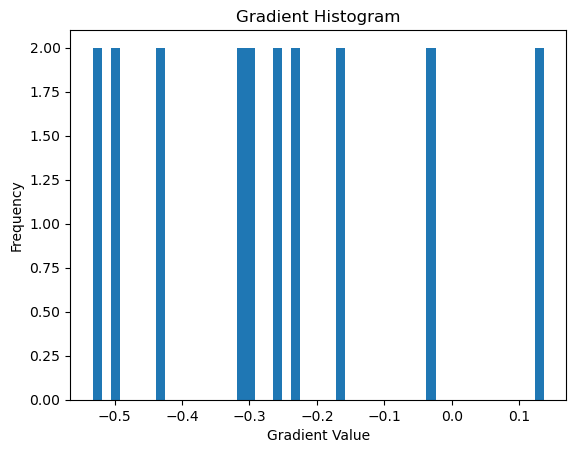

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax import linen as nn
from flax.training import train_state
import optax
# Define your model
class MyModel(nn.Module):
    def setup(self):
        self.dense = nn.Dense(10)

    def __call__(self, x):
        return self.dense(x)

# Create a dummy training state
def create_train_state():
    model = MyModel()
    params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 1)))['params']
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optax.adam(learning_rate=0.001),
    )

state = create_train_state()

# Function to compute gradients
def compute_gradients(state, x, y):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, x)
        loss = jnp.mean((logits - y) ** 2)
        return loss

    grads = jax.grad(loss_fn)(state.params)
    return grads

# Dummy data
x = jnp.ones((1, 1))
y = jnp.ones((1, 10))

grads = compute_gradients(state, x, y)

# Plot histogram of gradients
def plot_gradient_histogram(grads):
    flat_grads = [g.flatten() for g in jax.tree_util.tree_leaves(grads)]
    all_grads = np.concatenate(flat_grads)
    plt.hist(all_grads, bins=50)
    plt.title('Gradient Histogram')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.show()

plot_gradient_histogram(grads)


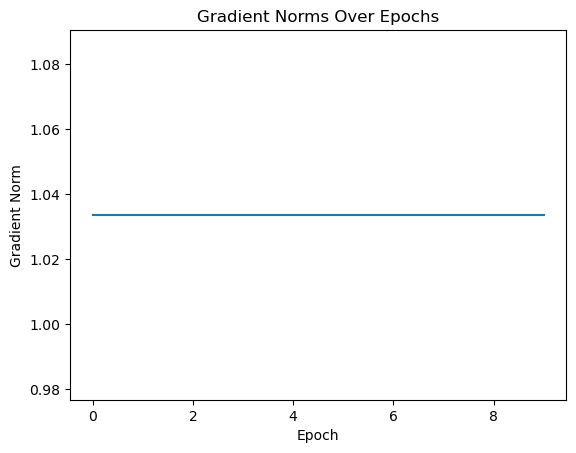

In [2]:
import matplotlib.pyplot as plt

# Function to compute gradient norms
def compute_gradient_norms(grads):
    return [jnp.linalg.norm(g).tolist() for g in jax.tree_util.tree_leaves(grads)]

# Simulate tracking gradient norms over epochs
epochs = 10
gradient_norms = []

for epoch in range(epochs):
    grads = compute_gradients(state, x, y)
    norms = compute_gradient_norms(grads)
    gradient_norms.append(np.mean(norms))  # Average norm across all parameters

plt.plot(range(epochs), gradient_norms)
plt.title('Gradient Norms Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.show()


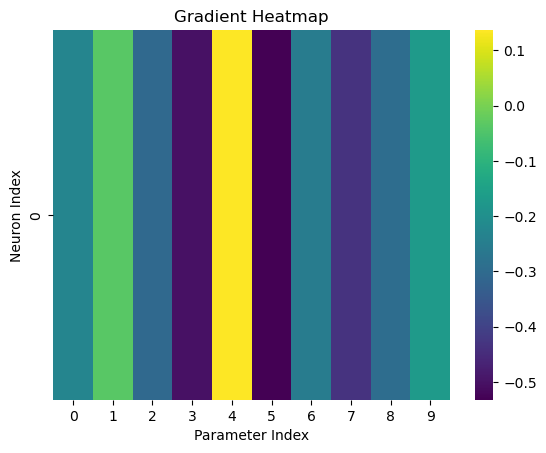

In [3]:
import seaborn as sns

def plot_gradient_heatmap(grad):
    grad_matrix = grad.reshape(-1, grad.shape[-1])  # Adjust as needed for your parameter shape
    sns.heatmap(grad_matrix, cmap='viridis', cbar=True)
    plt.title('Gradient Heatmap')
    plt.xlabel('Parameter Index')
    plt.ylabel('Neuron Index')
    plt.show()

# Assuming `grads` contains a specific weight matrix gradient
weight_grad = grads['dense']['kernel']  # Adjust based on actual parameter names
plot_gradient_heatmap(weight_grad)

ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

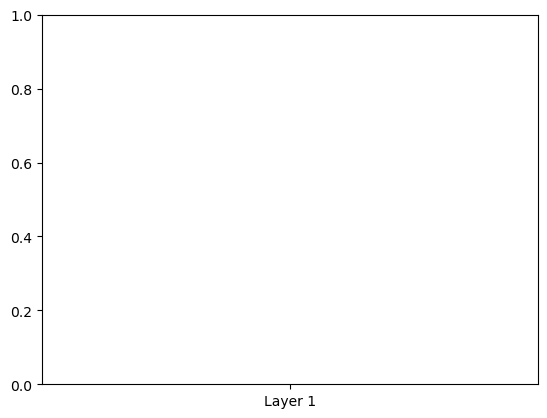

In [4]:
def plot_gradient_flow(grads, layer_names):
    gradient_flows = [jnp.linalg.norm(g).tolist() for g in jax.tree_util.tree_leaves(grads)]
    plt.plot(layer_names, gradient_flows, marker='o')
    plt.title('Gradient Flow Through Layers')
    plt.xlabel('Layer')
    plt.ylabel('Gradient Norm')
    plt.xticks(rotation=90)
    plt.show()

layer_names = ['Layer 1', 'Layer 2', 'Layer 3']  # Replace with actual layer names
plot_gradient_flow(grads, layer_names)

In [9]:
import seaborn as sns


def plot_gradients(grads, spatial_params, epoch):
    """
    Plot histogram of grads for the different layers, already excluding gradients masked to 0 due to sparse or local connectivity
    figured inspired on https://hassaanbinaslam.github.io/myblog/posts/2022-10-23-pytorch-vanishing-gradients-deep-neural-networks.html
    """
    fig, axs= plt.subplots(1, 3, figsize=(10.5,3))
    
    #input layer grads
    input_grads_ind = jnp.where(spatial_params['ALIFCell_0']['sparse_input'] == 1)
    sns.histplot(data=grads['ALIFCell_0']['input_weights'][input_grads_ind], bins=30, ax=axs[0], kde=True)
    axs[0].set_title('Input Weights')
    axs[0].set_xlabel("Grad magnitude", fontsize=11)
    # Count the number of NaNs in input grads
    input_nan_count = jnp.sum(jnp.isnan(grads['ALIFCell_0']['input_weights'][input_grads_ind]))
    # Count the number of infs in input grads
    input_inf_count = jnp.sum(jnp.isinf(grads['ALIFCell_0']['input_weights'][input_grads_ind]))
    axs[0].text(
    0.95,  # x-position (relative to plot, 0 is left, 1 is right)
    0.95,  # y-position (relative to plot, 0 is bottom, 1 is top)
    f'NaN count: {input_nan_count}\nInf count: {input_inf_count}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=axs[0].transAxes,  # Position relative to the specific axis (axs[0])
    bbox=dict(facecolor='white', alpha=0.5)  # Optional: adds a semi-transparent background box
    )

    #recurrent layer grads
    recurrent_grads_ind = jnp.where(spatial_params['ALIFCell_0']['M'] == 1)
    sns.histplot(data=grads['ALIFCell_0']['recurrent_weights'][recurrent_grads_ind], bins=30, ax=axs[1], kde=True)
    axs[1].set_title('Recurrent Weights')
    axs[1].set_xlabel("Grad magnitude", fontsize=11)
        
    # Output layer grads
    output_grads_ind = jnp.where(spatial_params['ReadOut_0']['sparse_readout'] == 1)
    sns.histplot(data=grads['ReadOut_0']['readout_weights'][output_grads_ind] , bins=10, ax=axs[2], kde=True)
    axs[2].set_title('Output Weights')
    axs[2].set_xlabel("Grad magnitude", fontsize=11)


    fig.suptitle(f"Epoch: {epoch}", fontsize=16)
    # Adjust layout to prevent overlap
    fig.tight_layout()
    

In [10]:
import jax.numpy as jnp
grads = {'ALIFCell_0':{}, 'ReadOut_0':{}}
grads['ALIFCell_0']['input_weights'] = jnp.array([1.,2.,3.,4.,5., jnp.nan])
grads['ALIFCell_0']['recurrent_weights'] = jnp.array([1.,2.,3.,4.,5., jnp.inf])
grads['ReadOut_0']['readout_weights'] = jnp.array([1.,2.,3.,4.,jnp.inf, jnp.nan])
mask = jnp.array([1.,1.,1.,1.,1.,1.])
spatial_params = {'ALIFCell_0':{"sparse_input":mask, "M":mask}, 'ReadOut_0':{"sparse_readout":mask}}




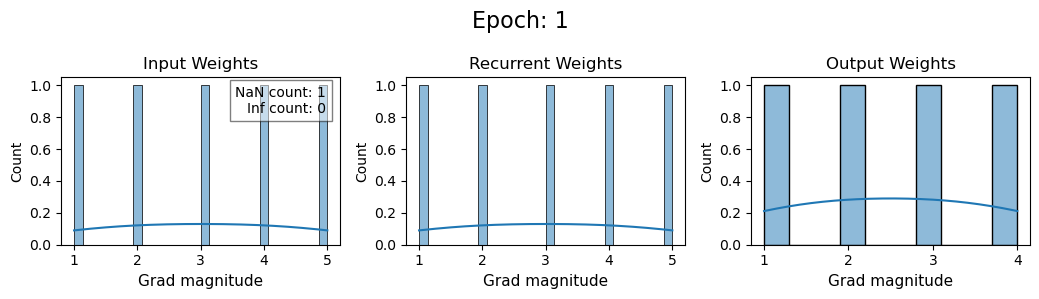

In [11]:
plot_gradients(grads, spatial_params, 1)